In [21]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree
import matplotlib.pylab as plt
from dmba import plotDecisionTree, gainsChart, liftChart
from dmba import classificationSummary
from sklearn.model_selection import cross_val_score
import graphviz

In [2]:
delays_df = pd.read_csv('https://raw.githubusercontent.com/timcsmith/MIS536-Public/master/Data/FlightDelays.csv')
delays_df.head()

,CRS_DEP_TIME,CARRIER,DEP_TIME,DEST,DISTANCE,FL_DATE,FL_NUM,ORIGIN,Weather,DAY_WEEK,DAY_OF_MONTH,TAIL_NUM,Flight Status
0,1455,OH,1455,JFK,184,01/01/2004,5935,BWI,0,4,1,N940CA,ontime
1,1640,DH,1640,JFK,213,01/01/2004,6155,DCA,0,4,1,N405FJ,ontime
2,1245,DH,1245,LGA,229,01/01/2004,7208,IAD,0,4,1,N695BR,ontime
3,1715,DH,1709,LGA,229,01/01/2004,7215,IAD,0,4,1,N662BR,ontime
4,1039,DH,1035,LGA,229,01/01/2004,7792,IAD,0,4,1,N698BR,ontime


In [3]:
delays_df['DAY_WEEK'].astype('category')

0       4
1       4
2       4
3       4
4       4
       ..
2196    6
2197    6
2198    6
2199    6
2200    6
Name: DAY_WEEK, Length: 2201, dtype: category
Categories (7, int64): [1, 2, 3, 4, 5, 6, 7]

In [4]:
delays_df['binned_CRS_DEP_TIME'] = pd.cut(delays_df.CRS_DEP_TIME, 8, labels=False)
delays_df['binned_CRS_DEP_TIME'].astype('category')

0       4
1       5
2       3
3       5
4       2
       ..
2196    0
2197    5
2198    5
2199    3
2200    5
Name: binned_CRS_DEP_TIME, Length: 2201, dtype: category
Categories (8, int64): [0, 1, 2, 3, 4, 5, 6, 7]

In [5]:
predictors_df = delays_df
columns = list(delays_df.columns)
columns.remove('DAY_OF_MONTH')
predictors_df = predictors_df[columns]

In [6]:
columns = list(predictors_df.columns)
columns

columns.remove('CRS_DEP_TIME')
columns.remove('DEP_TIME')
columns.remove('FL_DATE')
columns.remove('FL_NUM')
columns.remove('TAIL_NUM')
columns.remove('Flight Status')
predictors_df = predictors_df[columns]
predictors_df.columns

predictors_df.head()

,CARRIER,DEST,DISTANCE,ORIGIN,Weather,DAY_WEEK,binned_CRS_DEP_TIME
0,OH,JFK,184,BWI,0,4,4
1,DH,JFK,213,DCA,0,4,5
2,DH,LGA,229,IAD,0,4,3
3,DH,LGA,229,IAD,0,4,5
4,DH,LGA,229,IAD,0,4,2


In [7]:
predictors_df = pd.get_dummies(predictors_df, prefix_sep='_')
predictors_df.columns

Index(['DISTANCE', 'Weather', 'DAY_WEEK', 'binned_CRS_DEP_TIME', 'CARRIER_CO',
       'CARRIER_DH', 'CARRIER_DL', 'CARRIER_MQ', 'CARRIER_OH', 'CARRIER_RU',
       'CARRIER_UA', 'CARRIER_US', 'DEST_EWR', 'DEST_JFK', 'DEST_LGA',
       'ORIGIN_BWI', 'ORIGIN_DCA', 'ORIGIN_IAD'],
      dtype='object')

In [8]:
X = predictors_df
y = delays_df['Flight Status']
y = y == 'ontime'

train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)
train_X.head()

,DISTANCE,Weather,DAY_WEEK,binned_CRS_DEP_TIME,CARRIER_CO,CARRIER_DH,CARRIER_DL,CARRIER_MQ,CARRIER_OH,CARRIER_RU,CARRIER_UA,CARRIER_US,DEST_EWR,DEST_JFK,DEST_LGA,ORIGIN_BWI,ORIGIN_DCA,ORIGIN_IAD
1215,229,0,7,7,0,1,0,0,0,0,0,0,0,0,1,0,0,1
1476,214,0,3,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0
1897,214,0,2,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0
83,214,0,5,3,0,0,0,0,0,0,0,1,0,0,1,0,1,0
1172,213,0,6,4,0,0,1,0,0,0,0,0,0,1,0,0,1,0


In [37]:
clf=DecisionTreeClassifier(random_state=0)
clf.fit(train_X.drop(columns=['binned_CRS_DEP_TIME']), train_y)

DecisionTreeClassifier(random_state=0)

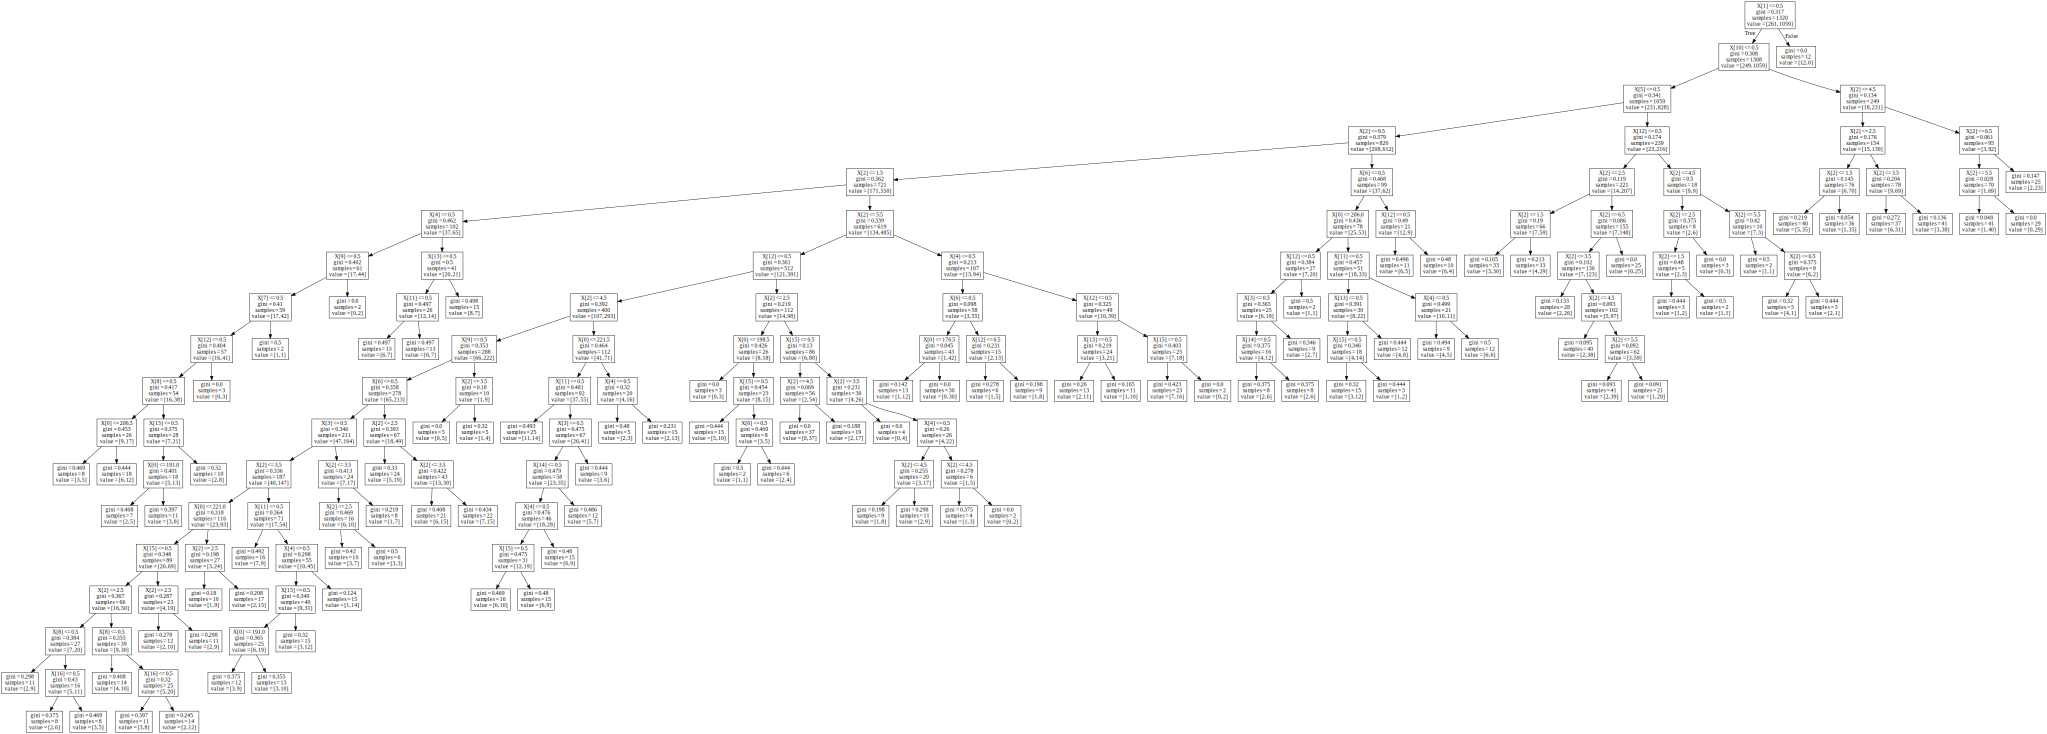

In [38]:
dot_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data) 
graph

In [42]:
classificationSummary(train_y,clf.predict(train_X.drop(columns=['binned_CRS_DEP_TIME'])))
print('\n*****************\n')
print()
classificationSummary(valid_y, clf.predict(valid_X.drop(columns=['binned_CRS_DEP_TIME'])))

Confusion Matrix (Accuracy 0.8174)

       Prediction
Actual    0    1
     0   52  209
     1   32 1027

*****************


Confusion Matrix (Accuracy 0.8150)

       Prediction
Actual   0   1
     0  35 132
     1  31 683


In [56]:
clf_1=DecisionTreeClassifier(random_state=1)
score_measure =[ 'precision','accuracy','recall']
param_grid = {
    'max_depth': [1, 5, 10, 20, 30, 40], 
    'min_samples_split': [1, 5, 10, 20, 40, 60, 80, 100], 
    'min_impurity_decrease': [0, 0.0005, 0.001, 0.005, 0.01], 
}
clf_best_prec=GridSearchCV(clf_1, param_grid,cv=10,scoring=score_measure[0],n_jobs=-1)
clf_best_prec.fit(train_X.drop(columns=['binned_CRS_DEP_TIME']), train_y)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [1, 5, 10, 20, 30, 40],
                         'min_impurity_decrease': [0, 0.0005, 0.001, 0.005,
                                                   0.01],
                         'min_samples_split': [1, 5, 10, 20, 40, 60, 80, 100]},
             scoring='precision')

In [57]:
print(score_measure, 'score: ', clf_best_prec.best_score_)
print('parametres:',clf_best_prec.best_params_)

['precision', 'accuracy', 'recall'] score:  0.818476714454191
parametres: {'max_depth': 10, 'min_impurity_decrease': 0, 'min_samples_split': 10}


In [58]:
clf_best_acc=GridSearchCV(clf_1, param_grid,cv=10,scoring=score_measure[1],n_jobs=-1)
clf_best_acc.fit(train_X.drop(columns=['binned_CRS_DEP_TIME']), train_y)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [1, 5, 10, 20, 30, 40],
                         'min_impurity_decrease': [0, 0.0005, 0.001, 0.005,
                                                   0.01],
                         'min_samples_split': [1, 5, 10, 20, 40, 60, 80, 100]},
             scoring='accuracy')

In [59]:
print(score_measure, 'score: ', clf_best_acc.best_score_)
print('parametres:',clf_best_acc.best_params_)

['precision', 'accuracy', 'recall'] score:  0.8121212121212121
parametres: {'max_depth': 5, 'min_impurity_decrease': 0.0005, 'min_samples_split': 5}


In [61]:
clf_best_rec=GridSearchCV(clf_1, param_grid,cv=10,scoring=score_measure[2],n_jobs=-1)
clf_best_rec.fit(train_X.drop(columns=['binned_CRS_DEP_TIME']), train_y)
print(score_measure, 'score: ', clf_best_rec.best_score_)
print('parametres:',clf_best_rec.best_params_)

['precision', 'accuracy', 'recall'] score:  1.0
parametres: {'max_depth': 1, 'min_impurity_decrease': 0, 'min_samples_split': 5}


In [62]:
classificationSummary(valid_y, clf_best_acc.predict(valid_X.drop(columns=['binned_CRS_DEP_TIME'])))
print("\n")
classificationSummary(valid_y, clf_best_prec.predict(valid_X.drop(columns=['binned_CRS_DEP_TIME'])))
print("\n")
classificationSummary(valid_y, clf_best_rec.predict(valid_X.drop(columns=['binned_CRS_DEP_TIME'])))
print("\n")

Confusion Matrix (Accuracy 0.8286)

       Prediction
Actual   0   1
     0  25 142
     1   9 705


Confusion Matrix (Accuracy 0.8218)

       Prediction
Actual   0   1
     0  32 135
     1  22 692


Confusion Matrix (Accuracy 0.8331)

       Prediction
Actual   0   1
     0  20 147
     1   0 714




best accuracy tree


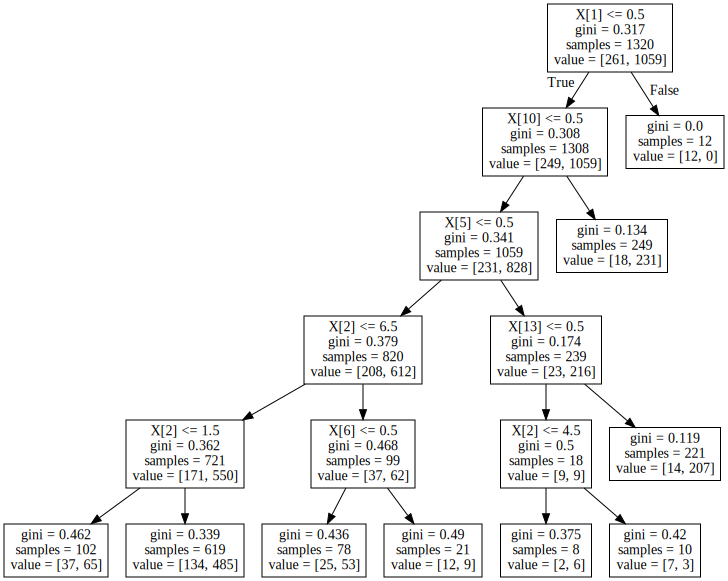

In [65]:
print('best accuracy tree')
best_accuracy_tree=clf_best_acc.best_estimator_
dot_data = tree.export_graphviz(best_accuracy_tree, out_file=None) 
graph = graphviz.Source(dot_data) 
graph

best precision tree


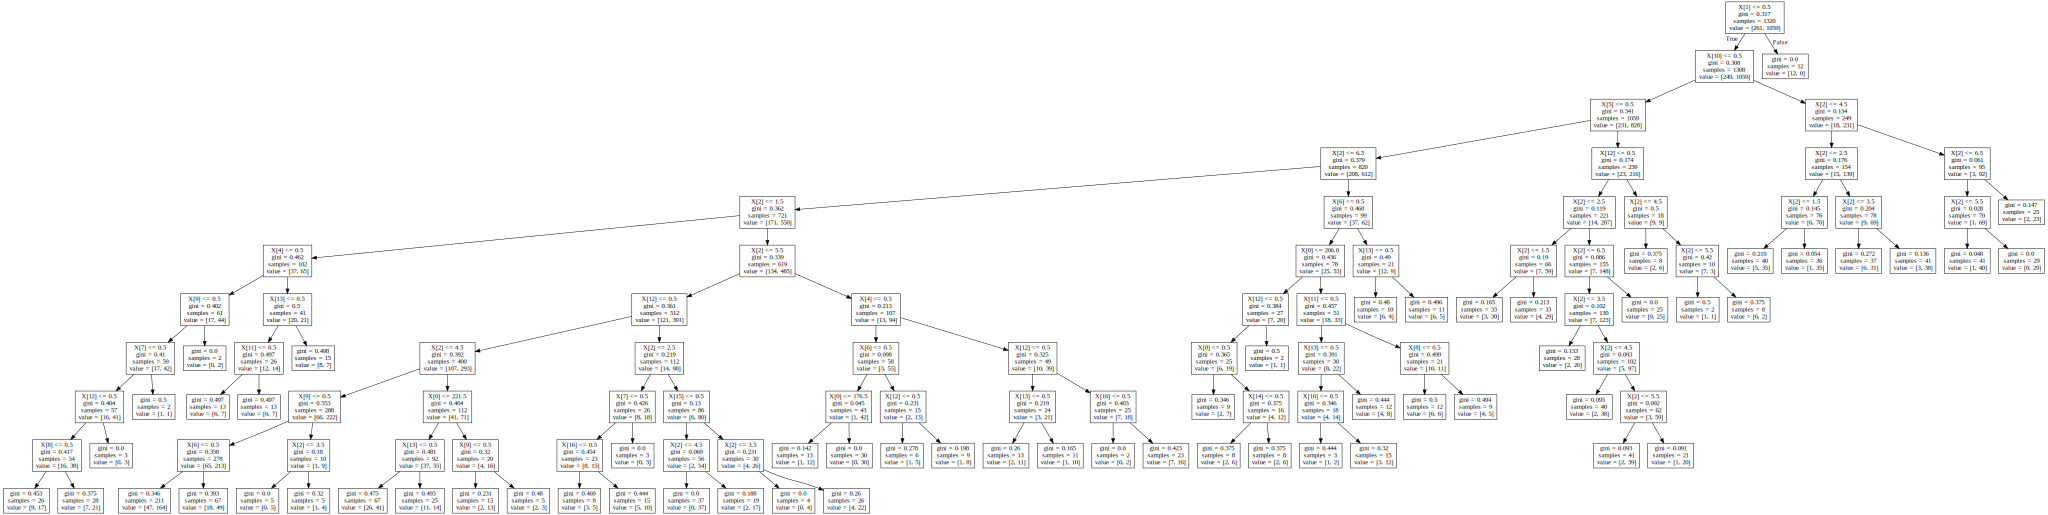

In [66]:
print('best precision tree')
best_precision_tree=clf_best_prec.best_estimator_
dot_data = tree.export_graphviz(best_precision_tree, out_file=None) 
graph = graphviz.Source(dot_data) 
graph

best recall tree


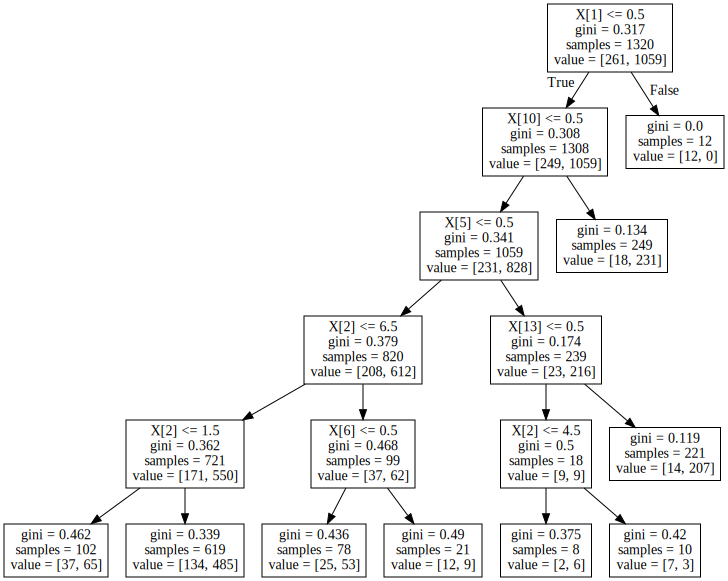

In [67]:
print('best recall tree')
best_recall_tree=clf_best_acc.best_estimator_
dot_data = tree.export_graphviz(best_recall_tree, out_file=None) 
graph = graphviz.Source(dot_data) 
graph

In [68]:
#part 2

In [71]:
train_X, valid_X, train_y, valid_y = train_test_split(X.drop(columns=['Weather']), y, test_size=0.4, random_state=1)
train_X.head()

,DISTANCE,DAY_WEEK,binned_CRS_DEP_TIME,CARRIER_CO,CARRIER_DH,CARRIER_DL,CARRIER_MQ,CARRIER_OH,CARRIER_RU,CARRIER_UA,CARRIER_US,DEST_EWR,DEST_JFK,DEST_LGA,ORIGIN_BWI,ORIGIN_DCA,ORIGIN_IAD
1215,229,7,7,0,1,0,0,0,0,0,0,0,0,1,0,0,1
1476,214,3,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0
1897,214,2,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0
83,214,5,3,0,0,0,0,0,0,0,1,0,0,1,0,1,0
1172,213,6,4,0,0,1,0,0,0,0,0,0,1,0,0,1,0


In [72]:
clf=DecisionTreeClassifier(random_state=0)
clf.fit(train_X.drop(columns=['binned_CRS_DEP_TIME']), train_y)

DecisionTreeClassifier(random_state=0)

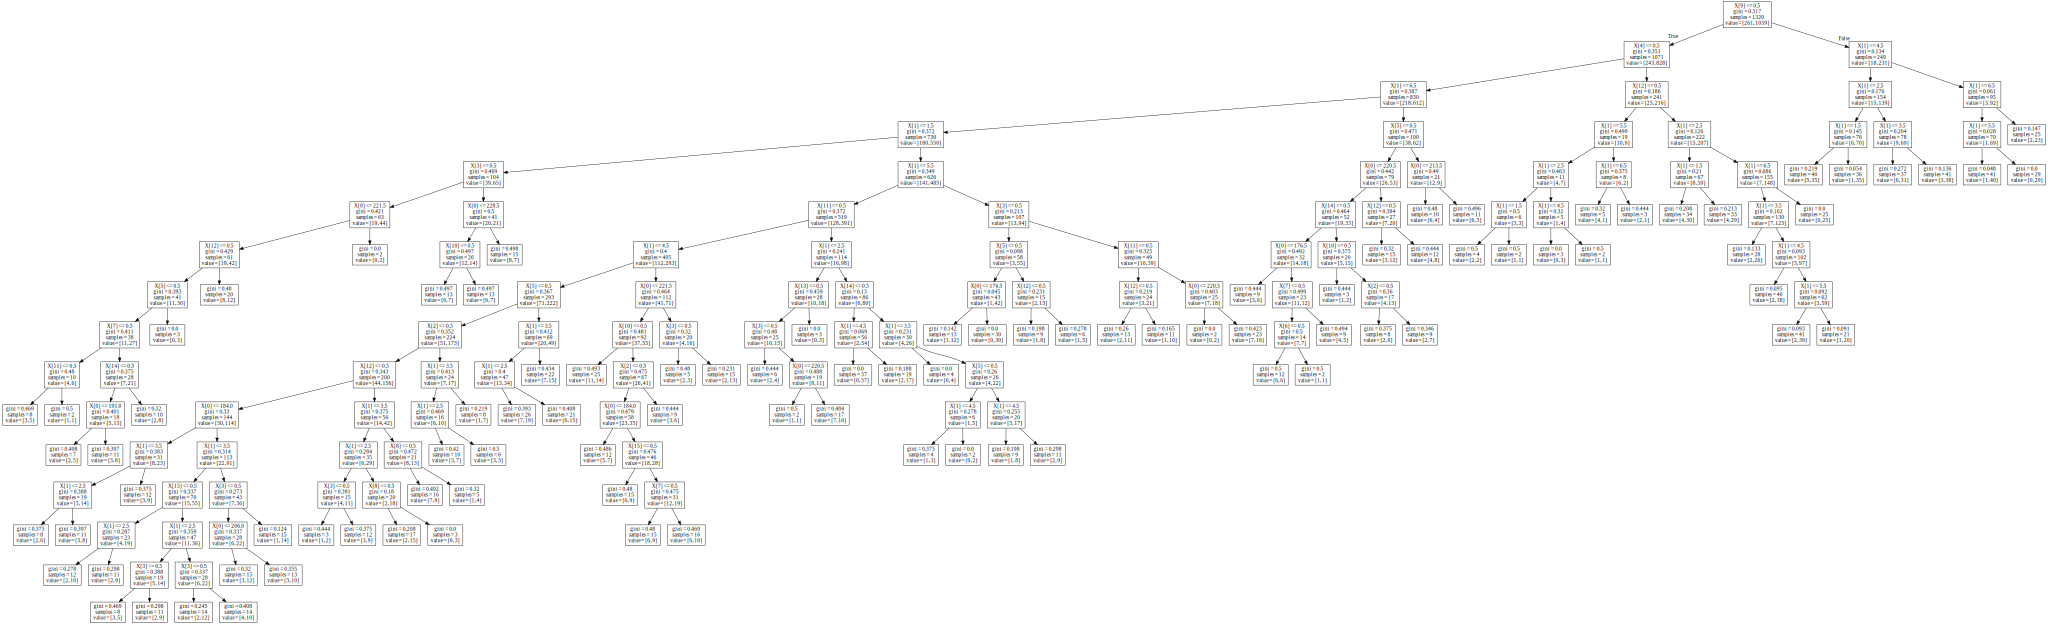

In [73]:
dot_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data) 
graph

In [74]:
classificationSummary(train_y,clf.predict(train_X.drop(columns=['binned_CRS_DEP_TIME'])))
print('\n*****************\n')
print()
classificationSummary(valid_y, clf.predict(valid_X.drop(columns=['binned_CRS_DEP_TIME'])))

Confusion Matrix (Accuracy 0.8083)

       Prediction
Actual    0    1
     0   42  219
     1   34 1025

*****************


Confusion Matrix (Accuracy 0.7923)

       Prediction
Actual   0   1
     0  15 152
     1  31 683


In [75]:
clf_1=DecisionTreeClassifier(random_state=1)
score_measure =[ 'precision','accuracy','recall']
param_grid = {
    'max_depth': [1, 5, 10, 20, 30, 40], 
    'min_samples_split': [1, 5, 10, 20, 40, 60, 80, 100], 
    'min_impurity_decrease': [0, 0.0005, 0.001, 0.005, 0.01], 
}
clf_best_prec=GridSearchCV(clf_1, param_grid,cv=10,scoring=score_measure[0],n_jobs=-1)
clf_best_prec.fit(train_X.drop(columns=['binned_CRS_DEP_TIME']), train_y)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [1, 5, 10, 20, 30, 40],
                         'min_impurity_decrease': [0, 0.0005, 0.001, 0.005,
                                                   0.01],
                         'min_samples_split': [1, 5, 10, 20, 40, 60, 80, 100]},
             scoring='precision')

In [76]:
print(score_measure, 'score: ', clf_best_prec.best_score_)
print('parametres:',clf_best_prec.best_params_)

['precision', 'accuracy', 'recall'] score:  0.811952697243625
parametres: {'max_depth': 5, 'min_impurity_decrease': 0, 'min_samples_split': 5}


In [77]:
clf_best_acc=GridSearchCV(clf_1, param_grid,cv=10,scoring=score_measure[1],n_jobs=-1)
clf_best_acc.fit(train_X.drop(columns=['binned_CRS_DEP_TIME']), train_y)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [1, 5, 10, 20, 30, 40],
                         'min_impurity_decrease': [0, 0.0005, 0.001, 0.005,
                                                   0.01],
                         'min_samples_split': [1, 5, 10, 20, 40, 60, 80, 100]},
             scoring='accuracy')

In [78]:
print(score_measure, 'score: ', clf_best_acc.best_score_)
print('parametres:',clf_best_acc.best_params_)

['precision', 'accuracy', 'recall'] score:  0.8022727272727274
parametres: {'max_depth': 5, 'min_impurity_decrease': 0.0005, 'min_samples_split': 5}


In [79]:
clf_best_rec=GridSearchCV(clf_1, param_grid,cv=10,scoring=score_measure[2],n_jobs=-1)
clf_best_rec.fit(train_X.drop(columns=['binned_CRS_DEP_TIME']), train_y)
print(score_measure, 'score: ', clf_best_rec.best_score_)
print('parametres:',clf_best_rec.best_params_)

['precision', 'accuracy', 'recall'] score:  1.0
parametres: {'max_depth': 1, 'min_impurity_decrease': 0, 'min_samples_split': 5}


In [87]:
print("accuracy based")
classificationSummary(valid_y, clf_best_acc.predict(valid_X.drop(columns=['binned_CRS_DEP_TIME'])))
print("\n")
print("precision based")
classificationSummary(valid_y, clf_best_prec.predict(valid_X.drop(columns=['binned_CRS_DEP_TIME'])))
print("\n")
print("recall based")
classificationSummary(valid_y, clf_best_rec.predict(valid_X.drop(columns=['binned_CRS_DEP_TIME'])))
print("\n")

accuracy based
Confusion Matrix (Accuracy 0.8070)

       Prediction
Actual   0   1
     0   4 163
     1   7 707


precision based
Confusion Matrix (Accuracy 0.8070)

       Prediction
Actual   0   1
     0   5 162
     1   8 706


recall based
Confusion Matrix (Accuracy 0.8104)

       Prediction
Actual   0   1
     0   0 167
     1   0 714




best accuracy tree


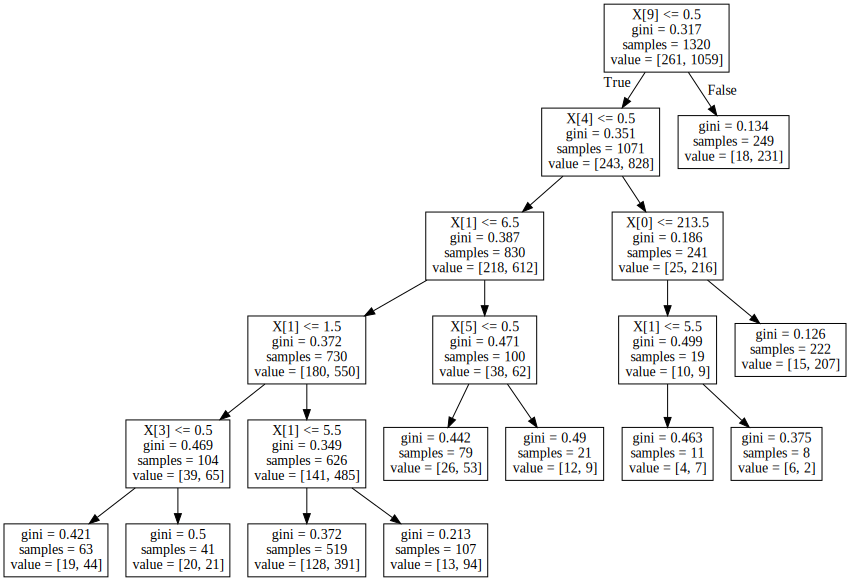

In [81]:
print('best accuracy tree')
best_accuracy_tree=clf_best_acc.best_estimator_
dot_data = tree.export_graphviz(best_accuracy_tree, out_file=None) 
graph = graphviz.Source(dot_data) 
graph

best precision tree


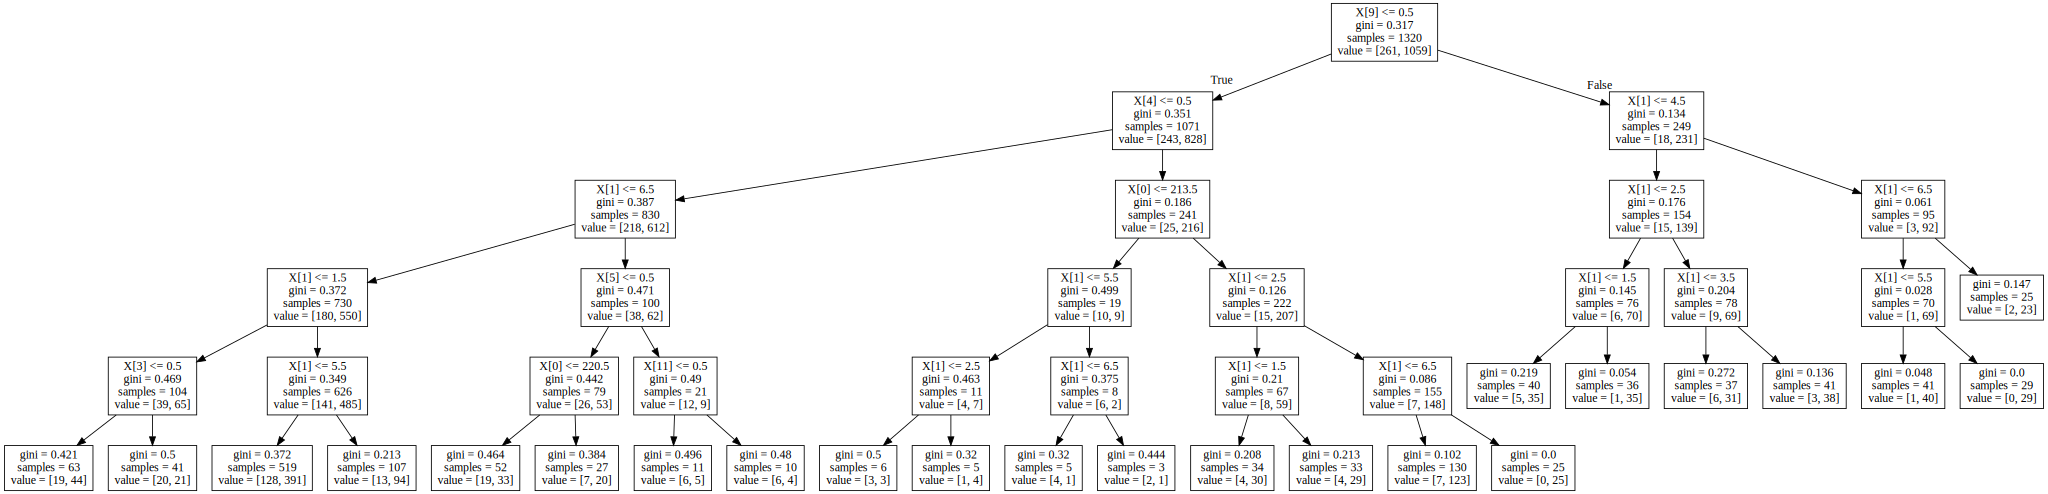

In [82]:
print('best precision tree')
best_precision_tree=clf_best_prec.best_estimator_
dot_data = tree.export_graphviz(best_precision_tree, out_file=None) 
graph = graphviz.Source(dot_data) 
graph

best recall tree


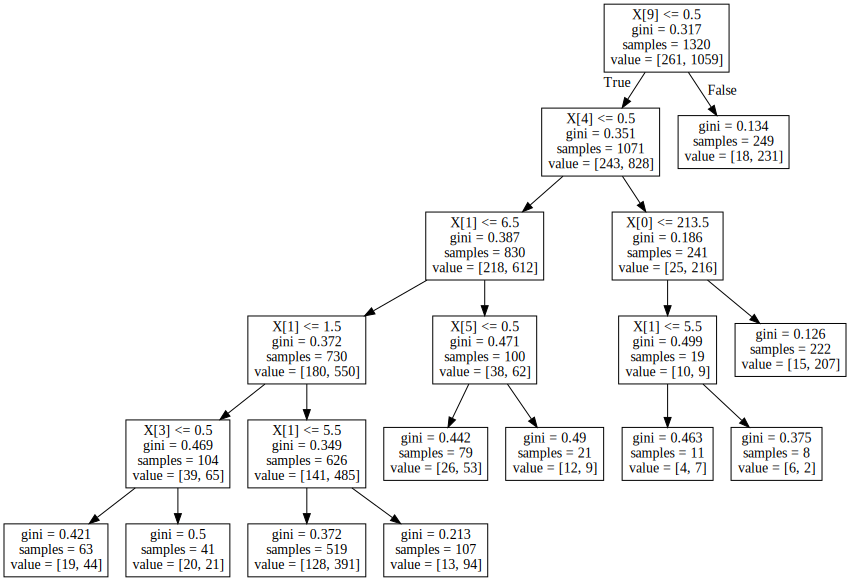

In [83]:
print('best recall tree')
best_recall_tree=clf_best_acc.best_estimator_
dot_data = tree.export_graphviz(best_recall_tree, out_file=None) 
graph = graphviz.Source(dot_data) 
graph

In [88]:
#from observing accuracy in in part 1 and part 2, it is evident that accuracy decreased when weather was removed from predictors
#best predictor changed to X[9] which is carrier_RU. 
#for the first part recall was best score_measure
#looking at confusion matrix for 2nd part, I can't suggest recall as score_measure